# Data extraction, transformation, and loading into a JSON file
This is part of the project described in <https://github.com/amchagas/OSH_papers_DB>, check the project readme for more details.

This notebook loads data sources and merges them in a single compressed JSON file.

In [1]:
import os
import re
import pandas as pd
import bibtexparser
import matplotlib.pyplot as plt
from pathlib import Path
from project_definitions import baseDir, dataSourceDir, dataOutDir, figDir, allDataFile
from project_definitions import store_data, load_data
from pprint import pprint
import html

## Bibtex sources

In [2]:
scieloSource = {
    'paths': [dataSourceDir / x for x in ("scielo.bib",)],
    'col_rename': {"crossref": "doi"},
    'transforms': [
        lambda x: x.map(html.unescape, na_action="ignore").str.replace("{", "").str.replace("}", "").str.strip(),
        lambda x: x.astype(int) if x.name == "year" else x,
    ],
}
scopusSource = {
    'paths': [dataSourceDir / x for x in ("scopus1.bib", "scopus2.bib")],
    'col_rename': {},
    'transforms': [
        lambda x: x.astype(int) if x.name == "year" else x,
    ],
}
wosSource = {
    'paths': [dataSourceDir / x for x in ("wos1.bib", "wos2.bib", "wos3.bib", "wos4.bib")],
    'col_rename': {},
    'transforms': [
        lambda x: x.str.replace("\\", "").str.replace("{", "").str.replace("}", "").str.strip(),
        lambda x: x.astype(int) if x.name == "year" else x,
    ],
}

In [3]:
def load_bibtex(bibtexSource):
    dfs = []
    for path in bibtexSource['paths']:
        with path.open() as f:
            df = pd.DataFrame(bibtexparser.load(f).entries)
        df['__bibtex_source'] = path.name
        dfs.append(df)
    cdf = pd.concat(dfs, join='outer', ignore_index=True)
    cdf = cdf.rename(columns=bibtexSource['col_rename'])
    for trans in bibtexSource['transforms']:
        cdf = cdf.transform(trans)
    return cdf

In [4]:
scieloData = load_bibtex(scieloSource)

<ipython-input-2-1ca024bfee1a>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  lambda x: x.map(html.unescape, na_action="ignore").str.replace("{", "").str.replace("}", "").str.strip(),


In [5]:
scopusData = load_bibtex(scopusSource)

In [6]:
wosData = load_bibtex(wosSource)

<ipython-input-2-1ca024bfee1a>:20: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  lambda x: x.str.replace("\\", "").str.replace("{", "").str.replace("}", "").str.strip(),


In [7]:
allDataList = [scieloData, scopusData, wosData]

In [8]:
allData = pd.concat(allDataList, join='outer', ignore_index=True)

In [9]:
store_data(allData, allDataFile)

In [10]:
assert allData.equals(load_data(allDataFile))

## CSV sources

In [11]:
plosData = pd.read_csv(dataSourceDir / 'plos-items.csv')
sel_article = plosData["Content Type (URL items only - Research Article, Web Article, Commentary, Video, Poster)"].eq("Research Article")
sel_hardware = plosData["Hardware or software"].eq("hardware")
plosData = plosData.loc[sel_article & sel_hardware]
assert not plosData["URI (DOI or URL)"].isna().any()
plosData['Title (URL items only)'] = plosData['Title (URL items only)'].str.strip()
plosData

,URI (DOI or URL),Hardware or software,Title (URL items only),Authors (URL items only),"Content Type (URL items only - Research Article, Web Article, Commentary, Video, Poster)",Date Published (URL items only),Source (URL items only),Summary,"Featured Rank (1 = Editor's Pick, 2-6 = Featured Research, 7-12 = Related Content)","Paywall (x = paywall, otherwise leave blank)","Featured Preprint (x = Featured Preprint, otherwise leave blank)",Remove (x = delete the item)
9,https://doi.org/10.1101/2020.05.01.071878,hardware,Bottom-Illuminated Orbital Shaker for Microalg...,"Jakub Nedbal, Lu Gao, Klaus Suhling",Research Article,2020-06-15,bioRxiv,NaN,NaN,NaN,NaN,NaN
10,https://doi.org/10.1101/2020.05.29.123166,hardware,"SiCTeC: an inexpensive, easily assembled Pelti...","Benjamin D. Knapp, Lillian Zhu, Kerwyn Casey...",Research Article,2020-06-15,bioRxiv,NaN,NaN,NaN,NaN,NaN
11,https://doi.org/10.1101/2020.04.23.056978,hardware,PlanktonScope: Affordable modular imaging plat...,"Thibaut Pollina, Adam G. Larson, Fabien Lombar...",Research Article,2020-06-15,bioRxiv,NaN,NaN,NaN,NaN,NaN
12,https://doi.org/10.1016/j.ohx.2020.e00112,hardware,Low-cost and precise inline pressure sensor ho...,"Luke Goertzen, Nicole Mehr, Manuel Lopez, Chet...",Research Article,2020-06-15,Hardware X,NaN,NaN,NaN,NaN,NaN
13,https://doi.org/10.1016/j.ohx.2020.e00113,hardware,DIY hybrid SSVEP-P300 LED stimuli for BCI plat...,"Sure jMouli, Ramaswamy Palaniappan",Research Article,2020-06-15,HardwareX,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
460,10.1371/journal.pone.0049365,hardware,"A Simple, Low-Cost Conductive Composite Materi...","Simon J. Leigh, Robert J. Bradley, Christopher...",Research Article,2012-11-21,PLOS ONE,NaN,NaN,NaN,NaN,NaN
461,http://www.rsc.org/images/loc/2012/pdf/T.4.111...,hardware,Portable Liquid Chromatography - PDF download,"Akihiko Ishida, Takehiro Fujimoto, Satoshi Yok...",Research Article,2012-10-01,RSC,NaN,NaN,NaN,NaN,NaN
462,10.1371/journal.pone.0030837,hardware,"The SpikerBox: A Low Cost, Open-Source BioAmpl...","Timothy C. Marzullo, Gregory J. Gage",Research Article,2012-03-21,PLOS ONE,NaN,NaN,NaN,NaN,NaN
464,10.1371/journal.pone.0023783,hardware,"CheapStat: An Open-Source, “Do-It-Yourself” Po...","Aaron A. Rowe, Andrew J. Bonham, Ryan J. White...",Research Article,2011-09-13,PLOS ONE,NaN,NaN,NaN,NaN,NaN


In [12]:
plos2bibtex = {
    "URI (DOI or URL)": "doi",
    "": "",
}

In [13]:
sel_new_doi = ~plosData["URI (DOI or URL)"].isin(allData.doi.values)
sel_new_doi.sum()

105

In [14]:
sel_new_title = ~plosData["Title (URL items only)"].isin(allData.title.values)
sel_new_title.sum()

95

In [15]:
# Same titles, different DOIs
x = plosData[["URI (DOI or URL)", "Title (URL items only)"]].loc[sel_new_doi & ~sel_new_title]
x['doi'] = [
    allData["doi"].loc[
        allData['title'].eq(y)
    ].squeeze()
    for y in x["Title (URL items only)"]
]
x

,URI (DOI or URL),Title (URL items only),doi
29,https://doi.org/10.1016/j.techfore.2020.119986,Towards national policy for open source hardwa...,10.1016/j.techfore.2020.119986
34,https://www.preprints.org/manuscript/202003.03...,Leveraging open hardware to alleviate the burd...,10.1371/journal.pbio.3000730
37,https://doi.org/10.1016/j.ohx.2020.e00107,Open-source five degree of freedom motion plat...,10.1016/j.ohx.2020.e00107
38,https://doi.org/10.1016/j.ohx.2020.e00102,"PlasPI marine cameras: Open-source, affordable...",10.1016/j.ohx.2020.e00102
280,https://doi.org/10.1016/j.ohx.2017.07.001,A programmable optical stimulator for the Dros...,10.1016/j.ohx.2017.07.001
284,http://www.appropedia.org/Free_and_open-source...,Free and open-source automated 3-D microscope,2020 10.1111/jmi.12433 3055 10.1111/jmi....
285,http://www.appropedia.org/Open-source_mobile_w...,Open-source mobile water quality testing platform,376 10.2166/washdev.2014.137 3562 10.21...
343,http://doi.org/10.1016/j.ohx.2016.07.001,Open source laboratory sample rotator mixer an...,10.1016/j.ohx.2016.07.001
347,http://doi.org/10.1016/j.ohx.2016.09.001,An open source automatic feeder for animal exp...,10.1016/j.ohx.2016.09.001
399,http://scitation.aip.org/content/aip/journal/r...,A one-piece 3D printed flexure translation sta...,10.1063/1.4941068


In [16]:
# Same DOI, different Titles
pprint(plosData["Title (URL items only)"].loc[~sel_new_doi & sel_new_title])
print()
pprint(allData["title"].loc[
    allData["doi"].eq('10.1371/journal.pone.0023783')
])

464    CheapStat: An Open-Source, “Do-It-Yourself” Po...
Name: Title (URL items only), dtype: object

3808    CheapStat: An Open-Source, ``Do-It-Yourself'' ...
Name: title, dtype: object


# All done, now just mess around

In [17]:
print(allData.shape)
print(allData.columns)

(4218, 60)
Index(['url', 'pages', 'doi', 'month', 'language', 'publisher', 'year',
       'volume', 'author', 'journal', 'title', 'ENTRYTYPE', 'ID',
       '__bibtex_source', 'source', 'document_type', 'abbrev_source_title',
       'isbn', 'keywords', 'author_keywords', 'abstract', 'affiliation',
       'note', 'art_number', 'editor', 'correspondence_address1', 'page_count',
       'issn', 'number', 'pubmed_id', 'coden', 'da', 'unique-id',
       'doc-delivery-number', 'journal-iso', 'usage-count-since-2013',
       'usage-count-last-180-days', 'times-cited',
       'number-of-cited-references', 'funding-text', 'funding-acknowledgement',
       'author-email', 'web-of-science-categories', 'research-areas',
       'keywords-plus', 'eissn', 'type', 'address', 'orcid-numbers',
       'article-number', 'researcherid-numbers', 'oa', 'organization',
       'booktitle', 'book-group-author', 'meeting', 'series', 'esi-hot-paper',
       'esi-highly-cited-paper', 'book-author'],
      dtype='obj

In [18]:
article_data = allData.loc[allData["ENTRYTYPE"].eq('article')]
print(article_data.shape)

(2076, 60)


In [19]:
dup_title = article_data.duplicated('title', keep=False)
dup_doi = article_data.duplicated('doi', keep=False)
nan_doi = article_data['doi'].isna()
print(
    dup_title.sum(),
    dup_doi.sum(),
    nan_doi.sum(),
    (dup_title & dup_doi).sum(),
    (dup_title & ~dup_doi).sum(),
)

261 1473 139 255 6


In [20]:
article_data.journal.value_counts()

Lecture Notes in Computer Science (including subseries Lecture Notes in Artificial Intelligence and Lecture Notes in Bioinformatics)    55
SENSORS                                                                                                                                 54
Sensors (Switzerland)                                                                                                                   49
HardwareX                                                                                                                               34
Advances in Intelligent Systems and Computing                                                                                           23
                                                                                                                                        ..
Journal of Electroanalytical Chemistry                                                                                                   1
FORESTS                    

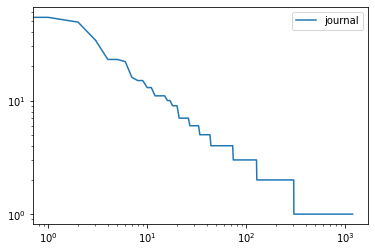

In [21]:
article_data.journal.value_counts().reset_index().plot(loglog=True)

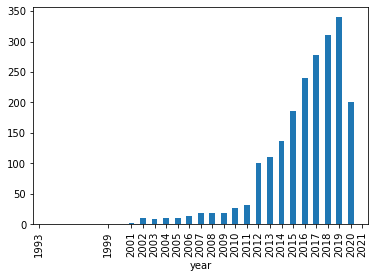

In [22]:
article_data.groupby('year').size().plot.bar()